In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, f1_score, matthews_corrcoef
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import time

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf

2025-06-22 01:31:54.967255: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-22 01:31:54.967311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-22 01:31:54.969762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-22 01:31:54.978874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-22 01:31:55.997677: W tensorflow/compiler/tf2

In [2]:
# Verificar si detecta GPUs
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-06-22 01:31:57.439670: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-22 01:31:57.494773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-22 01:31:57.494964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
base_dir = './Banana Ripeness Classification Dataset V2'
print(os.listdir(base_dir)) # Deberías ver ['train', 'valid', 'test']

['train', 'valid', 'test']


In [4]:
lr ="001"
Et = "8"
l_rate = 0.001
Epoch_test = 8

In [5]:
def save_test_accuracy(experiment_name, test_accuracy, filename='test_accuracy_log.csv'):
    new_entry = pd.DataFrame([{
        'experiment': experiment_name,
        'test_accuracy': test_accuracy
    }])

    if os.path.exists(filename):
        df_existing = pd.read_csv(filename)
        # Eliminar cualquier fila con el mismo experimento
        df_existing = df_existing[df_existing['experiment'] != experiment_name]
        # Agregar nueva entrada
        df_combined = pd.concat([df_existing, new_entry], ignore_index=True)
    else:
        df_combined = new_entry

    df_combined.to_csv(filename, index=False)
    print(f"Test accuracy for '{experiment_name}' saved to '{filename}'.")


In [6]:
class MetricsLogger(Callback):
    def __init__(self, validation_data, experiment_name=None):
        super(MetricsLogger, self).__init__()
        self.validation_data = validation_data
        self.history = []
        self.experiment_name = experiment_name
        self.epoch_start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time

        val_data, val_labels = self.validation_data
        val_preds = self.model.predict(val_data, verbose=0)
        val_preds_classes = np.argmax(val_preds, axis=1)
        val_true_classes = np.argmax(val_labels, axis=1)

        recall = recall_score(val_true_classes, val_preds_classes, average='macro')
        f1 = f1_score(val_true_classes, val_preds_classes, average='macro')
        mcc = matthews_corrcoef(val_true_classes, val_preds_classes)

        logs = logs or {}

        # Entrenamiento
        train_accuracy = logs.get('accuracy')
        train_loss = logs.get('loss')

        # Validación
        val_accuracy = logs.get('val_accuracy')
        val_loss = logs.get('val_loss')

        self.history.append({
            'experiment': self.experiment_name if self.experiment_name else 'default',
            'epoch': epoch + 1,
            'accuracy': train_accuracy,
            'loss': train_loss,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'recall': recall,
            'f1_score': f1,
            'mcc': mcc,
            'epoch_time': round(epoch_duration, 2)
        })

    def save_to_csv(self, filename='metrics_log.csv'):
        new_df = pd.DataFrame(self.history)

        if os.path.exists(filename):
            existing_df = pd.read_csv(filename)

            # Eliminar filas con experimentos ya existentes
            existing_df = existing_df[~existing_df['experiment'].isin(new_df['experiment'])]

            # Combinar con los nuevos datos
            combined_df = pd.concat([existing_df, new_df], ignore_index=True)
        else:
            combined_df = new_df

        combined_df.to_csv(filename, index=False)
        print(f"Metrics saved to '{filename}' with {len(new_df)} new rows.")


In [7]:

image_size = (224, 224)  # Tamaño compatible con VGG16
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'valid'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = valid_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Importante para la matriz de confusión
)


Found 9440 images belonging to 4 classes.
Found 2023 images belonging to 4 classes.
Found 2015 images belonging to 4 classes.


In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar pesos de VGG16

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate= l_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2025-06-22 01:31:58.039515: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-22 01:31:58.039717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-22 01:31:58.039806: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
def generator_to_arrays(generator):
    X_list, y_list = [], []
    for i in range(len(generator)):
        x, y = generator[i]
        X_list.append(x)  # <- aquí
        y_list.append(y)
    return np.concatenate(X_list), np.concatenate(y_list)

X_val, y_val = generator_to_arrays(valid_generator)
# Crear callback personalizado
metrics_logger = MetricsLogger(validation_data=(X_val, y_val), experiment_name=f'vgg16_{l_rate}_{Epoch_test}')

In [10]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_generator,
      epochs=Epoch_test,
      validation_data=valid_generator,
      callbacks=[metrics_logger]
  )

metrics_logger.save_to_csv('resultados_modelos.csv')

Epoch 1/8


2025-06-22 01:32:03.489648: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-22 01:32:07.394333: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd600d4e230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-22 01:32:07.394416: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-06-22 01:32:07.399398: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750555927.489984    6151 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 [==============================] - 85s 273ms/step - loss: 0.5222 - accuracy: 0.8445 - val_loss: 0.1161 - val_accuracy: 0.9639
Epoch 2/8
295/295 [==============================] - 84s 285ms/step - loss: 0.2439 - accuracy: 0.9136 - val_loss: 0.0929 - val_accuracy: 0.9738
Epoch 3/8
295/295 [==============================] - 83s 281ms/step - loss: 0.2009 - accuracy: 0.9291 - val_loss: 0.1045 - val_accuracy: 0.9684
Epoch 4/8
295/295 [==============================] - 81s 273ms/step - loss: 0.1730 - accuracy: 0.9380 - val_loss: 0.0818 - val_accuracy: 0.9758
Epoch 5/8
295/295 [==============================] - 82s 276ms/step - loss: 0.1625 - accuracy: 0.9414 - val_loss: 0.0786 - val_accuracy: 0.9743
Epoch 6/8
295/295 [==============================] - 83s 282ms/step - loss: 0.1425 - accuracy: 0.9493 - val_loss: 0.0950 - val_accuracy: 0.9694
Epoch 7/8
295/295 [==============================] - 82s 278ms/step - loss: 0.1498 - accuracy: 0.9464 - val_loss: 0.0705 - val_accuracy: 0.9778
Ep

63/63 [==============================] - 7s 114ms/step
Classification Report
              precision    recall  f1-score   support

    overripe       0.99      0.99      0.99       479
        ripe       0.98      0.97      0.97       520
      rotten       0.97      0.98      0.97       541
      unripe       1.00      0.99      0.99       475

    accuracy                           0.98      2015
   macro avg       0.98      0.98      0.98      2015
weighted avg       0.98      0.98      0.98      2015

Confusion Matrix


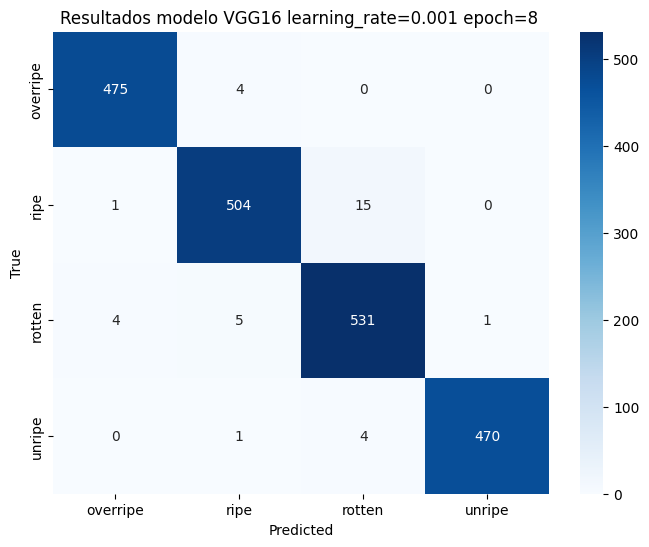

In [11]:
# Predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Reporte y matriz de confusión
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)

# Visualizar la matriz
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.title(f"Resultados modelo VGG16 learning_rate={l_rate} epoch={Epoch_test} ")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f'Matrices de confusion/VGG16/matriz_confusion_lr{lr}_epoch{Et}.png', bbox_inches='tight')
plt.show()


In [12]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(test_generator.classes, y_pred)
experiment_name = f'vgg16_{l_rate}_{Epoch_test}'

save_test_accuracy(experiment_name, test_accuracy)

Test accuracy for 'vgg16_0.001_8' saved to 'test_accuracy_log.csv'.


In [13]:
#from google.colab import files

# Guarda el modelo localmente en Colab
model.save(f'modelos/VGG16_{lr}_{Et}.h5')
print("saved model")

# Descarga el archivo
#files.download('VGG16.h5')

saved model


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
